# 1. Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import gdown
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# 2. Load the Data

In [4]:
url = 'https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K'
output = './data/sonnets.txt'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /Users/jordanspooner/git/tensorflow-basics/Memory_and_Words/data/sonnets.txt
100%|██████████| 93.6k/93.6k [00:00<00:00, 43.2MB/s]


'./data/sonnets.txt'

In [6]:
# Define path for file with sonnets
SONNETS_FILE = './data/sonnets.txt'

# Read the data
with open(SONNETS_FILE) as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


# 3. Tokenizing the Text

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 # remember to add 1 for OOV characters

In [8]:
# The first example of the corpus is a string and looks like:
corpus[0]

'from fairest creatures we desire increase,'

In [10]:
# If you pass this text directly into the texts_to_sequences method you will get an unexpected result:
tokenizer.texts_to_sequences(corpus[0][:5]) # just showing the first five characters

[[], [], [58], [], []]

In [11]:
# This happened because texts_to_sequences expects a list and you are providing a string. 
# However a string is still and iterable in Python so you will get the word index of every character in the string.

# Instead you need to place the example whithin a list before passing it to the method:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

In [12]:
# Notice that you received the sequence wrapped inside a list so in order to get only the desired sequence 
# you need to explicitly get the first item in the list like this:

tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

# 4. Generating n_grams

In [13]:
def n_gram_seqs(corpus, tokenizer):
	input_sequences = []

	for line in corpus:
		token_list = tokenizer.texts_to_sequences([line])[0]

		for i in range(1, len(token_list)):
			# Generate subphrase
			n_gram_sequence = token_list[:i+1]
			# Append subphrase to input_sequences list
			input_sequences.append(n_gram_sequence)
	 
	return input_sequences

In [14]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [15]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"number of sequences in corpus {len(corpus)}")
print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

number of sequences in corpus 2159
n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


# 5. Add Padding to the Sequences

In [16]:
def pad_seqs(input_sequences, maxlen):
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')
    
    return padded_sequences

In [17]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

array([[  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213],
       [417, 877, 166, 213, 517]], dtype=int32)

In [18]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


# 6. Split the Data into Features and Labels

In [19]:
# Before feeding the data into the neural network we should split it into features and labels. 
# In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

def features_and_labels(input_sequences, total_words):
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [23]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}") # (num_sequences, num_target_words)
print("\nfeatures look like this:\n") # (num_sequences, length_of_max_token)
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,  34],
       [  0,   0,  34, 417],
       [  0,  34, 417, 877],
       [ 34, 417, 877, 166],
       [417, 877, 166, 213]], dtype=int32)

In [21]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


# 7. Create the Model

In [24]:
def create_model(total_words, max_sequence_len):
    
    model = Sequential()

    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [25]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 7s 12ms/step - loss: 6.8864 - accuracy: 0.0228
Epoch 2/50
484/484 [==============================] - 6s 13ms/step - loss: 6.4367 - accuracy: 0.0294
Epoch 3/50
484/484 [==============================] - 6s 12ms/step - loss: 6.2041 - accuracy: 0.0421
Epoch 4/50
484/484 [==============================] - 6s 12ms/step - loss: 5.9482 - accuracy: 0.0515
Epoch 5/50
484/484 [==============================] - 6s 12ms/step - loss: 5.6475 - accuracy: 0.0627
Epoch 6/50
484/484 [==============================] - 6s 12ms/step - loss: 5.2876 - accuracy: 0.0792
Epoch 7/50
484/484 [==============================] - 6s 12ms/step - loss: 4.8888 - accuracy: 0.0978
Epoch 8/50
484/484 [==============================] - 6s 12ms/step - loss: 4.4631 - accuracy: 0.1325
Epoch 9/50
484/484 [==============================] - 6s 12ms/step - loss: 4.0369 - accuracy: 0.1852
Epoch 10/50
484/484 [==============================] - 6s 12ms/step - loss: 3.6195 - accura

# 8. Evaluating the History

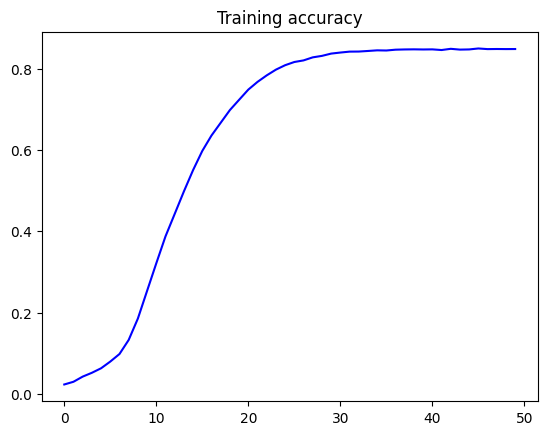

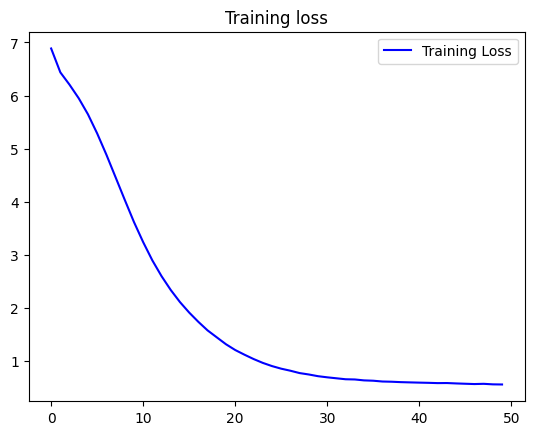

In [26]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

# 9. See the Model in Action!

In [27]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope what should make me told me in me with thine eyes might see no thee such thy heart lies 'will ' ' ' dearer bring his friend dead night thee to show ' ' to me mad seen friend itself so bold and part one twain blamed lies 'will ' bring forth so so say thy change ' say i bring ' bring thee for thy sake hath his verse translate cause ' so great 'will ' light light so near both depends twain had quenched her men's more 'will ' say so best ' see thy friend ' thine
